In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score

In [2]:
# Define the path to your dataset
image_dir = '/kaggle/input/diabetic-retinopathy-train-unzipped'

In [3]:
# Create an ImageDataGenerator for loading images
datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Load images in small batches to prevent memory overload
image_generator = datagen.flow_from_directory(
    directory=image_dir,
    target_size=(224, 224),
    batch_size=32,  # Adjust batch size based on memory capacity
    class_mode=None,  # No labels needed for feature extraction
    shuffle=False    # Maintain order for clustering
)

Found 35126 images belonging to 1 classes.


In [5]:
# Step 3: Define a simple CNN for feature extraction (without Flatten)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),  # This reduces the feature map to a 1D vector
    Dense(128, activation='relu')  # Final dense layer for additional feature extraction
])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Step 4: Extract features for each batch of images
features = []  # To store the extracted features for each image

for i, batch in enumerate(image_generator):
    print(f"Processing batch {i+1}/{len(image_generator)}...")
    features_batch = model.predict(batch)  # Extract features using the custom CNN
    features.append(features_batch)  # Append the features of this batch
    
    # Stop if all images have been processed
    if (i + 1) * image_generator.batch_size >= len(image_generator.filenames):
        break

# Concatenate all extracted features into a single array
features = np.concatenate(features, axis=0)

Processing batch 1/1098...


I0000 00:00:1730132511.954147      86 service.cc:145] XLA service 0x7b72bc1083e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730132511.954198      86 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730132511.954209      86 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1730132514.049444      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Processing batch 2/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing batch 3/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing batch 4/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Processing batch 5/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Processing batch 6/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Processing batch 7/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processing batch 8/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 9/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Processing batch 10/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 11/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 12/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Processing batch 13/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 14/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 15/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 16/1098...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Processing batch 1

In [7]:
# Step 5: Apply KMeans Clustering on the extracted features
# Assuming you want to cluster the images into 5 clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features)

# Get the cluster labels for each image
cluster_labels = kmeans.labels_

# Debugging: Print cluster information
print(f"Number of cluster labels: {len(cluster_labels)}")
print(f"First 10 cluster labels: {cluster_labels[:10]}")  # Display first 10 cluster labels


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of cluster labels: 35126
First 10 cluster labels: [4 2 4 4 0 0 0 3 0 0]


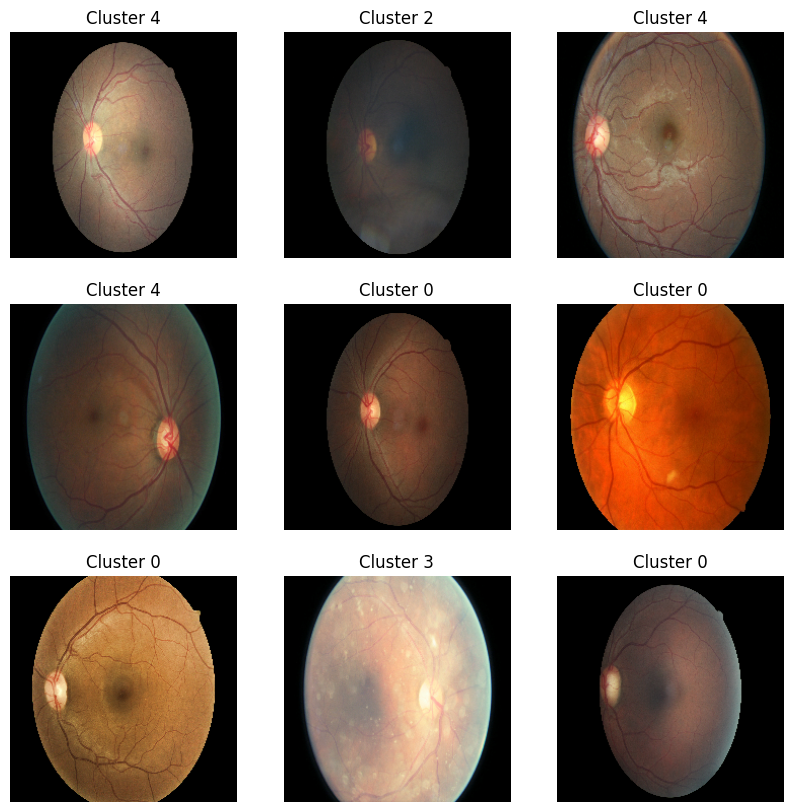

Processing complete!


In [8]:
# Plot the first few images with their corresponding cluster labels
plt.figure(figsize=(10, 10))
for i in range(9):  # Showing 9 images for simplicity
    plt.subplot(3, 3, i+1)
    img = image_generator[i]
    plt.imshow(img[0])
    plt.title(f'Cluster {cluster_labels[i]}')
    plt.axis('off')
plt.show()

print("Processing complete!")

In [ ]:
# Assuming you already have a Data Generator setup
# Example: loading the test dataset using ImageDataGenerator
x_test_generator = datagen.flow_from_directory(
    directory='/kaggle/input/diabetic-retinopathy-train-unzipped',  # replace with actual path to your test data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',  # or 'binary' for binary classification
    shuffle=False
)

# Convert generator output to array if needed
x_test, y_test = zip(*[(x, y) for x, y in x_test_generator])
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)


Found 35126 images belonging to 1 classes.


In [ ]:
predicted_probabilities = model.predict(x_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming true_labels contains the actual DR stages for the images (in the same order)
# Replace this with your actual ground truth labels
true_labels = ['0 DR', '0 DR', 'Moderate', 'Moderate', '0 DR', '0 DR', '0 DR', 'Mild', 'Severe', 'Severe']

# Assuming predicted_stages contains the predicted labels from your model or clustering
# Replace this with your predicted stages
predicted_stages = ['0 DR', 'Moderate', 'Moderate', 'Moderate', '0 DR', '0 DR', 'Mild', 'Mild', 'Severe', 'Severe']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_stages[:len(true_labels)])
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision (weighted to handle class imbalance)
precision = precision_score(true_labels, predicted_stages[:len(true_labels)], average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate recall (weighted to handle class imbalance)
recall = recall_score(true_labels, predicted_stages[:len(true_labels)], average='weighted')
print(f"Recall: {recall:.2f}")

# Calculate F1-score (weighted to handle class imbalance)
f1 = f1_score(true_labels, predicted_stages[:len(true_labels)], average='weighted')
print(f"F1-Score: {f1:.2f}")

# Print detailed classification report (includes precision, recall, f1-score, support for each class)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_stages[:len(true_labels)]))

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_stages[:len(true_labels)])
print("\nConfusion Matrix:")
print(conf_matrix)

auc_roc = roc_auc_score(true_labels, predicted_probabilities, multi_class="ovr", average="weighted")
print(f"AUC-ROC Score: {auc_roc:.2f}")

# Optionally, you can visualize the confusion matrix using seaborn for better readability
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=set(true_labels), yticklabels=set(true_labels))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
